In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from PIL import Image


In [2]:
train_df = pd.read_csv('C:\\IDL_project\\final_train_data.csv')
test_df = pd.read_csv('C:\\IDL_project\\final_test_data.csv')

train_df.shape

(10772, 2)

In [3]:
train_df = train_df[~train_df['ImagePath'].str.endswith(('aug.jpg', '_aug2.jpg', '_aug1.jpg', 'aug3.jpg', 'aug4.jpg'))]
train_df.shape

(8012, 2)

In [4]:
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.shape

(10015, 2)

In [5]:
combined_df.value_counts('BinaryType')

BinaryType
0    8061
1    1954
Name: count, dtype: int64

In [6]:
import os
from matplotlib.pylab import shuffle
import pandas as pd
malignant_dir = 'C:\\IDL_project\\Dataset\\Malignant'

image_paths = [os.path.join(malignant_dir, fname) for fname in os.listdir(malignant_dir)
               if fname.lower().endswith(('.jpg'))]

# Create DataFrame
malignant_df = pd.DataFrame({
    'ImagePath': image_paths,
    'BinaryType': 1
})

combined_df = pd.concat([combined_df, malignant_df], ignore_index=True)

# Shuffle the combined DataFrame
combined_df = combined_df.sample(frac=1, random_state=None).reset_index(drop=True)
combined_df.shape

(16605, 2)

In [7]:
from sklearn.model_selection import train_test_split

# Check class distribution
print(combined_df['BinaryType'].value_counts())

# Stratified split: 80% train, 20% test
train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['BinaryType'],
    random_state=42  # for reproducibility
)

BinaryType
1    8544
0    8061
Name: count, dtype: int64


In [8]:
print(train_df['BinaryType'].value_counts())
print(test_df['BinaryType'].value_counts())

BinaryType
1    6835
0    6449
Name: count, dtype: int64
BinaryType
1    1709
0    1612
Name: count, dtype: int64


In [9]:
import torchvision.transforms as transforms
import torch
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),                # Resize to slightly larger
    transforms.RandomCrop(224),                   # Random crop to target size
    transforms.RandomHorizontalFlip(p=0.5),       # Flip images for invariance
    transforms.RandomRotation(degrees=15),        # Small rotations
    transforms.ColorJitter(                       # Change brightness/contrast
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),               # No crop or flip for val/test
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [10]:
# Load images and apply transformations (No Dataset class needed)
#train_images = torch.stack([transform_train(Image.open(p).convert('RGB')) for p in train_df['ImagePath'].tolist()])
#test_images = torch.stack([transform_val(Image.open(p).convert('RGB')) for p in test_df['ImagePath'].tolist()])

#import torch

# Save tensors
#torch.save(train_images, 'train_images.pt')
#torch.save(test_images, 'test_images.pt')



In [11]:
train_images = torch.load('train_images.pt')
test_images = torch.load('test_images.pt')

# Convert labels to tensors
train_labels = torch.tensor(train_df['BinaryType'].values, dtype=torch.long)
test_labels = torch.tensor(test_df['BinaryType'].values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
model = models.resnet18(pretrained=True)

# Modify the classifier for binary classification (0/1)
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)

c:\Users\ishaa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ishaa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

labels = train_df['BinaryType'].values  # Should be 0 and 1
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

alpha = 0.9  # Between 0 (no balancing) and 1 (fully balanced)
soft_weights = (1 - alpha) * np.ones_like(class_weights) + alpha * class_weights

class_weights_tensor = torch.tensor(soft_weights, dtype=torch.float).to(device)
print(class_weights_tensor)

tensor([1.0269, 0.9746], device='cuda:0')


In [14]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.2)
optimizer = optim.AdamW(model.fc.parameters(), lr=0.00005, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

In [15]:
from tqdm import tqdm

# Lists to save metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_acc = 0.0

num_epochs = 20

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ---------- TRAIN ----------
    model.train()
    running_loss, correct = 0.0, 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ---------- EVAL ----------
    model.eval()
    test_loss, test_correct = 0.0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_correct += (outputs.argmax(1) == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)
    scheduler.step(test_loss)

    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    # ---------- LOG ----------
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" Test Loss: {avg_test_loss:.4f} |  Test Acc: {test_acc:.4f}")


    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"C:\\IDL_project\\BestModel\\BestModel9\\best_model.pt")
        print(f"Saved new best model with Test Acc: {test_acc:.4f}")



Epoch 1/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.27it/s]


Train Loss: 0.6455 | Train Acc: 0.6581
 Test Loss: 0.6000 |  Test Acc: 0.7353
Saved new best model with Test Acc: 0.7353

Epoch 2/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.31it/s]


Train Loss: 0.5571 | Train Acc: 0.7870
 Test Loss: 0.5393 |  Test Acc: 0.8133
Saved new best model with Test Acc: 0.8133

Epoch 3/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.26it/s]


Train Loss: 0.5271 | Train Acc: 0.8187
 Test Loss: 0.5149 |  Test Acc: 0.8329
Saved new best model with Test Acc: 0.8329

Epoch 4/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.53it/s]


Train Loss: 0.5074 | Train Acc: 0.8412
 Test Loss: 0.4943 |  Test Acc: 0.8503
Saved new best model with Test Acc: 0.8503

Epoch 5/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 53.09it/s]


Train Loss: 0.4991 | Train Acc: 0.8456
 Test Loss: 0.4836 |  Test Acc: 0.8654
Saved new best model with Test Acc: 0.8654

Epoch 6/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.57it/s]


Train Loss: 0.4943 | Train Acc: 0.8508
 Test Loss: 0.4895 |  Test Acc: 0.8594

Epoch 7/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 53.22it/s]


Train Loss: 0.4874 | Train Acc: 0.8597
 Test Loss: 0.4832 |  Test Acc: 0.8669
Saved new best model with Test Acc: 0.8669

Epoch 8/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.82it/s]


Train Loss: 0.4820 | Train Acc: 0.8619
 Test Loss: 0.4812 |  Test Acc: 0.8672
Saved new best model with Test Acc: 0.8672

Epoch 9/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 53.00it/s]


Train Loss: 0.4833 | Train Acc: 0.8614
 Test Loss: 0.4797 |  Test Acc: 0.8714
Saved new best model with Test Acc: 0.8714

Epoch 10/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.85it/s]


Train Loss: 0.4795 | Train Acc: 0.8659
 Test Loss: 0.4809 |  Test Acc: 0.8714

Epoch 11/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.65it/s]


Train Loss: 0.4775 | Train Acc: 0.8701
 Test Loss: 0.4757 |  Test Acc: 0.8753
Saved new best model with Test Acc: 0.8753

Epoch 12/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.74it/s]


Train Loss: 0.4761 | Train Acc: 0.8675
 Test Loss: 0.4682 |  Test Acc: 0.8844
Saved new best model with Test Acc: 0.8844

Epoch 13/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.87it/s]


Train Loss: 0.4759 | Train Acc: 0.8719
 Test Loss: 0.4799 |  Test Acc: 0.8717

Epoch 14/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 53.06it/s]


Train Loss: 0.4751 | Train Acc: 0.8724
 Test Loss: 0.4735 |  Test Acc: 0.8805

Epoch 15/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.76it/s]


Train Loss: 0.4727 | Train Acc: 0.8745
 Test Loss: 0.4629 |  Test Acc: 0.8901
Saved new best model with Test Acc: 0.8901

Epoch 16/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.78it/s]


Train Loss: 0.4716 | Train Acc: 0.8756
 Test Loss: 0.4828 |  Test Acc: 0.8711

Epoch 17/20


Testing: 100%|██████████| 104/104 [00:02<00:00, 51.79it/s]


Train Loss: 0.4726 | Train Acc: 0.8725
 Test Loss: 0.4731 |  Test Acc: 0.8796

Epoch 18/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.69it/s]


Train Loss: 0.4720 | Train Acc: 0.8742
 Test Loss: 0.4692 |  Test Acc: 0.8859

Epoch 19/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 52.85it/s]


Train Loss: 0.4700 | Train Acc: 0.8764
 Test Loss: 0.4763 |  Test Acc: 0.8808

Epoch 20/20


Testing: 100%|██████████| 104/104 [00:01<00:00, 53.12it/s]

Train Loss: 0.4714 | Train Acc: 0.8760
 Test Loss: 0.4975 |  Test Acc: 0.8609


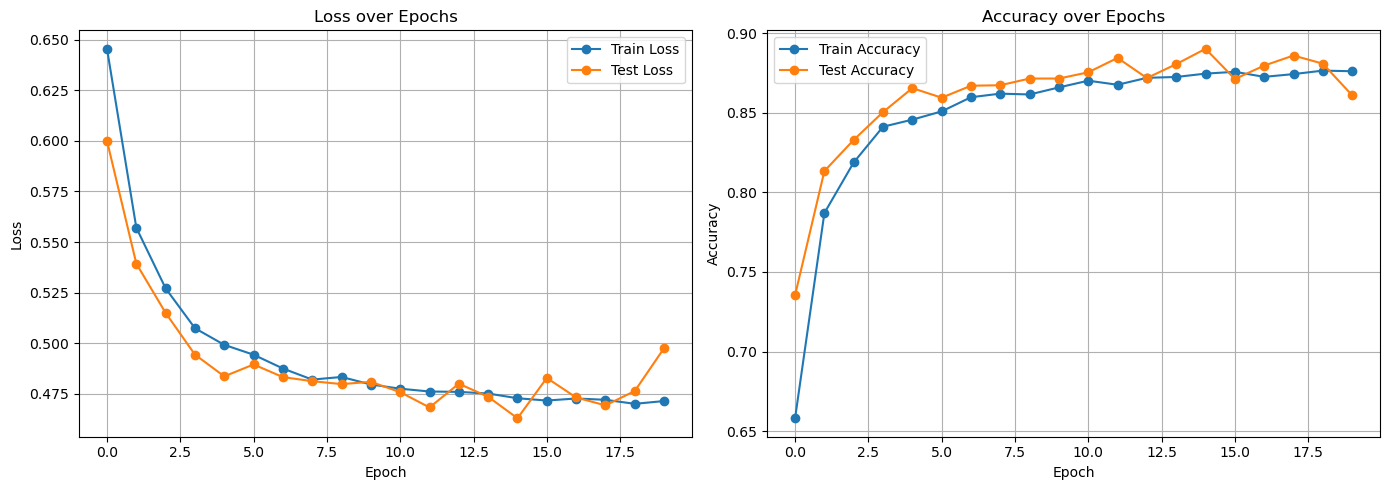

In [16]:
import matplotlib.pyplot as plt

# Plotting training and testing loss
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


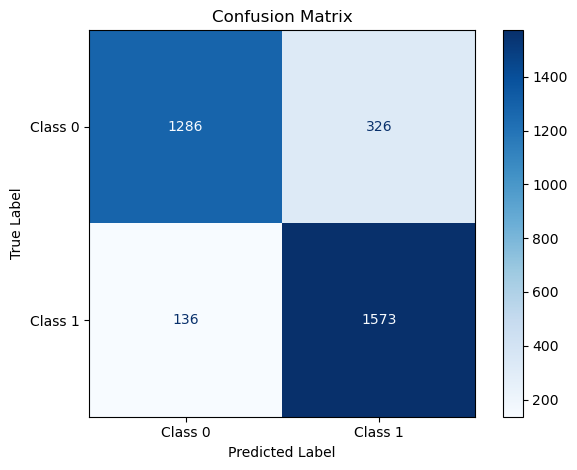

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: define class names
class_names = ['Class 0', 'Class 1']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()